### Imports

In [22]:
import numpy as np
import ROOT
import pandas as pd
import matplotlib.pyplot as plt
import energyflow as ef
from energyflow.archs.dnn import DNN
import data_handler as dh
import omnifold
from omnifold_bdt import binned_omnifold, unbinned_omnifold
import energyflow as ef
import modplot
from omnifold import DataLoader, MLP, MultiFold, PET
import time

### Plot Style

In [2]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

# Settings

In [3]:
num_data = 100000
itnum = 3

In [4]:
datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=num_data, exclude_keys=['particles']),
            'Herwig': ef.zjets_delphes.load('Herwig', num_data=num_data, exclude_keys=['particles'])}

synthetic, nature = datasets['Pythia26'], datasets['Herwig']
herwig_genjet_pt = nature["gen_jets"][:,0]
herwig_simjet_pt = nature["sim_jets"][:,0]
pythia_genjet_pt = synthetic["gen_jets"][:,0]
pythia_simjet_pt = synthetic["sim_jets"][:,0]
synthetic_jetpt_cut = (pythia_simjet_pt>150)
nature_jetpt_cut = (herwig_simjet_pt>150)
pass_reco_mask = synthetic_jetpt_cut
print(len(pythia_simjet_pt[synthetic_jetpt_cut])/len(pythia_simjet_pt))
# dummy_ones = np.ones(len(synthetic_jetpt_cut))
# pass_reco_mask=np.full_like(pass_reco_mask, True)
obs_multifold = ['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass']

0.84391


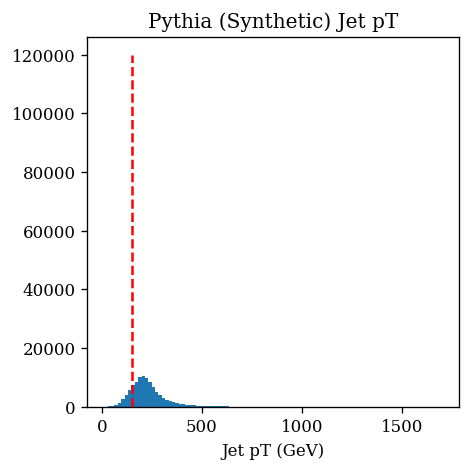

In [5]:
fig = plt.figure()
plt.hist(pythia_simjet_pt, bins=100)
plt.xlabel("Jet pT (GeV)")
plt.title("Pythia (Synthetic) Jet pT")
plt.vlines(150, 0, 120000, color='red', linestyle='dashed')
fig.savefig(f'./plots/pythia_pT_150.png', bbox_inches='tight')

In [6]:
# a dictionary to hold information about the observables
obs = {}

# the jet mass and histogram style information
obs.setdefault('Mass', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_jets'][:,3],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 75), 'ylim': (0, 0.065),
    'xlabel': r'Jet Mass $m$ [GeV]', 'symbol': r'$m$',
    'ylabel': r'Normalized Cross Section [GeV$^{-1}$]',
    'stamp_xy': (0.425, 0.65),
})

# the constituent multiplicity and histogram style information
obs.setdefault('Mult', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_mults'],
    'nbins_det': 80, 'nbins_mc': 80,
    'xlim': (0, 80), 'ylim': (0, 0.065),
    'xlabel': 'Jet Constituent Multiplicity $M$', 'symbol': r'$M$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.42, 0.65),
})

# the jet width and histogram style information
obs.setdefault('Width', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_widths'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.6), 'ylim': (0, 10),
    'xlabel': r'Jet Width $w$', 'symbol': r'$w$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the N-subjettiness ratio and histogram style information
obs.setdefault('Tau21', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_tau2s']/(dset[ptype + '_widths'] + 10**-50),
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 1.2), 'ylim': (0, 3),
    'xlabel': r'$N$-subjettiness Ratio $\tau_{21}^{(\beta=1)}$', 'symbol': r'$\tau_{21}^{(\beta=1)}$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# the groomed momentum fraction and histogram style information
obs.setdefault('zg', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_zgs'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.5), 'ylim': (0, 9),
    'xlabel': r'Groomed Jet Momentum Fraction $z_g$', 'symbol': r'$z_g$',
    'ylabel': 'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the groomed jet mass and histogram style information
obs.setdefault('SDMass', {}).update({
    'func': lambda dset, 
    ptype: np.log(dset[ptype + '_sdms']**2/
                                       dset[ptype + '_jets'][:,0]**2 + 10**-100),
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (-14, -2), 'ylim': (0, 0.3),
    'xlabel': r'Soft Drop Jet Mass $\ln\rho$', 'symbol': r'$\ln\rho$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '"Truth"'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
dnn_unbinned_multi_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}
bdt_unbinned_multi_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:orange', 'zorder': 3}
bdt_binned_single_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:purple', 'zorder': 3}
bdt_unbinned_single_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:blue', 'zorder': 3}

In [7]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():

    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic, 'gen'), ob['func'](synthetic, 'sim')
    ob['truthobs'], ob['dataobs'] = ob['func'](nature, 'gen'), ob['func'](nature, 'sim')
    
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]
    
    print('Done with', obkey)

Done with Mass
Done with Mult
Done with Width
Done with Tau21
Done with zg
Done with SDMass


# Unbinned DNN Multifold

In [8]:
MC_gen = np.asarray([obs[obkey]['genobs'] for obkey in obs_multifold]).T
MC_reco = np.asarray([obs[obkey]['simobs'] for obkey in obs_multifold]).T
data_reco = np.asarray([obs[obkey]['dataobs'] for obkey in obs_multifold]).T
combined_step1_data = np.concatenate((MC_reco[pass_reco_mask], data_reco[nature_jetpt_cut]), axis=0)
normalized_MC_reco = (MC_reco - np.mean(combined_step1_data, axis=0))/np.std(combined_step1_data, axis=0)
print(np.mean(combined_step1_data, axis=0))
normalized_data_reco = (data_reco - np.mean(combined_step1_data, axis=0))/np.std(combined_step1_data, axis=0)

combined_step2_data = np.concatenate((MC_gen, MC_gen), axis=0)
normalized_MC_gen = (MC_gen - np.mean(combined_step2_data, axis=0))/np.std(combined_step2_data, axis=0)

MC_dataloader = DataLoader(reco = normalized_MC_reco,
                           gen = normalized_MC_gen,
                           pass_reco = pass_reco_mask,
                           normalize = True)
data_dataloader = DataLoader(reco = normalized_data_reco,
                             pass_reco = nature_jetpt_cut,
                             normalize = True)
ndim = len(obs_multifold) #The number of features present in your dataset
reco_model = MLP(ndim)
gen_model = MLP(ndim)
omnifold_dnn = MultiFold(
    "BDT Omnifold paper",
    reco_model,
    gen_model,
    data_dataloader, # a dataloader instance containing the measured data
    MC_dataloader # a dataloader instance containing the simulation
)
start_time = time.time()
omnifold_dnn.Unfold()
omnifold_dnn_weights = omnifold_dnn.weights_push
end_time = time.time()
dnn_unbinned_multi_time = end_time-start_time
print(f"Total time {end_time-start_time}")

[19.52273219 19.26784136  0.14621386  0.65903917  0.24477786 -6.99586075]
INFO: Creating weights ...
INFO: Creating pass gen flag ...
INFO: Normalizing sum of weights to 1000000 ...
INFO: Creating weights ...
INFO: Normalizing sum of weights to 1000000 ...
1562 training steps at reco and 1562 steps at gen
ITERATION: 1
RUNNING STEP 1
Last val loss 6.78254508972168
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 8.084305763244629
INFO: Dumping training history ...
ITERATION: 2
RUNNING STEP 1
Last val loss 6.873164176940918
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 8.068205833435059
INFO: Dumping training history ...
ITERATION: 3
RUNNING STEP 1
Last val loss 6.902701377868652
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 8.06644058227539
INFO: Dumping training history ...
Total time 246.00749135017395


2024-10-21 16:23:15.863794: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Unbinned BDT Multifold

In [9]:
mc_entries = np.asarray([(obs[obkey]['genobs']) for obkey in obs_multifold]).T
sim_entries = np.asarray([(obs[obkey]['simobs']) for obkey in obs_multifold]).T
measured_entries = np.asarray([(obs[obkey]['dataobs'][nature_jetpt_cut]) for obkey in obs_multifold]).T

pass_truth_mask = np.full(len(sim_entries), True)

In [10]:
start_time = time.time()

multifold_ws_bdt, MC_test_bdt, _, _ = unbinned_omnifold(
    mc_entries, 
    sim_entries, 
    measured_entries, 
    pass_reco_mask, 
    pass_truth_mask, 
    itnum)
end_time = time.time()
bdt_unbinned_multi_time = end_time-start_time
print(f"Total time {end_time-start_time}")

Starting iteration 0
Starting iteration 1
Starting iteration 2
Total time 229.5304307937622


# Unbinned BDT Singlefold

In [11]:
bdt_unbinned_single_results = []
start_time = time.time()

for i in range(len(obs_multifold)):
    omnifold_weights, MC_test_bdt_single, _, _  = unbinned_omnifold(mc_entries[:,i], sim_entries[:,i], measured_entries[:,i], pass_reco_mask, pass_truth_mask, itnum)
    bdt_unbinned_single_results.append((omnifold_weights, MC_test_bdt_single))
end_time = time.time()
bdt_unbinned_single_time = end_time-start_time
print(f"Total time {end_time-start_time}")

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total time 267.15927934646606


# Binned BDT Singlefold

In [12]:
sim_data_mass, sim_data_width, sim_data_mult, sim_data_lnrho, sim_data_zgs, sim_data_tau21 = [], [], [], [], [], []
mc_data_mass, mc_data_width, mc_data_mult, mc_data_lnrho, mc_data_zgs, mc_data_tau21 = [], [], [], [], [], []
meas_data_mass, meas_data_width, meas_data_mult, meas_data_lnrho, meas_data_zgs, meas_data_tau21 = [], [], [], [], [], []

for i in range(len(measured_entries)):
    meas_data_mass.append(measured_entries[i][0])
    meas_data_mult.append(measured_entries[i][1])
    meas_data_width.append(measured_entries[i][2])
    meas_data_tau21.append(measured_entries[i][3])
    meas_data_zgs.append(measured_entries[i][4])
    meas_data_lnrho.append(measured_entries[i][5])
    
for i in range(len(mc_entries)):
    mc_data_mass.append(mc_entries[i][0])
    mc_data_mult.append(mc_entries[i][1])
    mc_data_width.append(mc_entries[i][2])
    mc_data_tau21.append(mc_entries[i][3])
    mc_data_zgs.append(mc_entries[i][4])
    mc_data_lnrho.append(mc_entries[i][5])
for i in range(len(sim_entries)):
    sim_data_mass.append(sim_entries[i][0])
    sim_data_mult.append(sim_entries[i][1])
    sim_data_width.append(sim_entries[i][2])
    sim_data_tau21.append(sim_entries[i][3])
    sim_data_zgs.append(sim_entries[i][4])
    sim_data_lnrho.append(sim_entries[i][5])


#Binned Data
bins_mass, bin_low_mass, bin_high_mass = obs['Mass']['nbins_det'], obs['Mass']['xlim'][0], obs['Mass']['xlim'][1]
bins_widths, bin_low_widths, bin_high_widths  = obs['Width']['nbins_det'], obs['Width']['xlim'][0], obs['Width']['xlim'][1]
bins_mult, bin_low_mult, bin_high_mult  = obs['Mult']['nbins_det'], obs['Mult']['xlim'][0], obs['Mult']['xlim'][1]
bins_lnrho, bin_low_lnrho, bin_high_lnrho  = obs['SDMass']['nbins_det'], obs['SDMass']['xlim'][0], obs['SDMass']['xlim'][1]
bins_zgs, bin_low_zgs, bin_high_zgs  = obs['zg']['nbins_det'], obs['zg']['xlim'][0], obs['zg']['xlim'][1]
bins_tau21, bin_low_tau21, bin_high_tau21  = obs['Tau21']['nbins_det'], obs['Tau21']['xlim'][0], obs['Tau21']['xlim'][1]

meas_data_mass_binned = ROOT.TH1D("meas_mass_hist", "meas_mass_hist", bins_mass, bin_low_mass, bin_high_mass)
meas_data_width_binned = ROOT.TH1D("meas_width_hist", "meas_width_hist", bins_widths, bin_low_widths, bin_high_widths)
meas_data_mult_binned = ROOT.TH1D("meas_mult_hist", "meas_mult_hist", bins_mult, bin_low_mult, bin_high_mult)
meas_data_lnrho_binned = ROOT.TH1D("meas_lnrho_hist", "meas_lnrho_hist", bins_lnrho, bin_low_lnrho, bin_high_lnrho)
meas_data_zgs_binned = ROOT.TH1D("meas_zgs_hist", "meas_zgs_hist", bins_zgs, bin_low_zgs, bin_high_zgs)
meas_data_tau21_binned = ROOT.TH1D("meas_tau21_hist", "meas_tau21_hist", bins_tau21, bin_low_tau21, bin_high_tau21)

response_mass = ROOT.RooUnfoldResponse(bins_mass, bin_low_mass, bin_high_mass, bins_mass, bin_low_mass, bin_high_mass)
response_width = ROOT.RooUnfoldResponse(bins_widths, bin_low_widths, bin_high_widths, bins_widths, bin_low_widths, bin_high_widths)
response_mult = ROOT.RooUnfoldResponse(bins_mult, bin_low_mult, bin_high_mult, bins_mult, bin_low_mult, bin_high_mult)
response_lnrho = ROOT.RooUnfoldResponse(bins_lnrho, bin_low_lnrho, bin_high_lnrho, bins_lnrho, bin_low_lnrho, bin_high_lnrho)
response_zgs = ROOT.RooUnfoldResponse(bins_zgs, bin_low_zgs, bin_high_zgs, bins_zgs, bin_low_zgs, bin_high_zgs)
response_tau21 = ROOT.RooUnfoldResponse(bins_tau21, bin_low_tau21, bin_high_tau21, bins_tau21, bin_low_tau21, bin_high_tau21)

In [13]:
#Unbinned data and fill response matrices
def build_data(
        response, 
        initial_mc_list, 
        initial_sim_list,
        pass_reco_mask,
        initial_measured_list, 
        measured_hist, 
    ):
    print(len(initial_sim_list), len(initial_mc_list), len(pass_reco_mask))
    for (sim, MC, pass_reco) in zip(initial_sim_list, initial_mc_list, pass_reco_mask):
        if pass_reco:
            response.Fill(sim, MC)
        else:
            response.Miss(MC)
    for measured in np.asarray(initial_measured_list):
        measured_hist.Fill(measured)
    return response, measured_hist

response_mass, meas_data_mass_binned = build_data(
    response_mass,
    mc_data_mass,
    sim_data_mass,
    pass_reco_mask,
    meas_data_mass,
    meas_data_mass_binned
)

response_mult, meas_data_mult_binned = build_data(
    response_mult,
    mc_data_mult,
    sim_data_mult,
    pass_reco_mask,
    meas_data_mult,
    meas_data_mult_binned
)

response_width, meas_data_width_binned = build_data(
    response_width,
    mc_data_width,
    sim_data_width,
    pass_reco_mask,
    meas_data_width,
    meas_data_width_binned
)

response_tau21, meas_data_tau21_binned = build_data(
    response_tau21,
    mc_data_tau21,
    sim_data_tau21,
    pass_reco_mask,
    meas_data_tau21,
    meas_data_tau21_binned
)

response_zgs, meas_data_zgs_binned = build_data(
    response_zgs,
    mc_data_zgs,
    sim_data_zgs,
    pass_reco_mask,
    meas_data_zgs,
    meas_data_zgs_binned
)

response_lnrho, meas_data_lnrho_binned = build_data(
    response_lnrho,
    mc_data_lnrho,
    sim_data_lnrho,
    pass_reco_mask,
    meas_data_lnrho,
    meas_data_lnrho_binned
)

100000 100000 100000
100000 100000 100000
100000 100000 100000
100000 100000 100000
100000 100000 100000
100000 100000 100000


In [14]:
IBU_mass = ROOT.RooUnfoldBayes(response_mass, meas_data_mass_binned, itnum)
h_mass_ibu = IBU_mass.Hunfold()
IBU_mult = ROOT.RooUnfoldBayes(response_mult, meas_data_mult_binned, itnum)
h_mult_ibu = IBU_mult.Hunfold()
IBU_width = ROOT.RooUnfoldBayes(response_width, meas_data_width_binned, itnum)
h_width_ibu = IBU_width.Hunfold()
IBU_tau21 = ROOT.RooUnfoldBayes(response_tau21, meas_data_tau21_binned, itnum)
h_tau21_ibu = IBU_tau21.Hunfold()
IBU_zg = ROOT.RooUnfoldBayes(response_zgs, meas_data_zgs_binned, itnum)
h_zg_ibu = IBU_zg.Hunfold()
IBU_SDMass = ROOT.RooUnfoldBayes(response_lnrho, meas_data_lnrho_binned, itnum)
h_SDMass_ibu = IBU_SDMass.Hunfold()
ibu_hist_dict = {"Mass":h_mass_ibu,
                 "Mult":h_mult_ibu,
                 "Width":h_width_ibu,
                 "Tau21":h_tau21_ibu,
                 "zg":h_zg_ibu,
                 "SDMass":h_SDMass_ibu}
start_time = time.time()
for obkey,ob in obs.items():
    histogram = ibu_hist_dict[obkey]
    bin_centers = [histogram.GetBinCenter(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
    counts = [histogram.GetBinContent(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
    bin_edges = [histogram.GetBinLowEdge(bin) for bin in range(1, histogram.GetNbinsX() + 2)]
    bin_errors = [histogram.GetBinError(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
    
    # Calculate the density-normalized histogram using np.histogram
    density_counts, _ = np.histogram(bin_centers, bins=bin_edges, weights=counts, density=True)
    bin_errors = bin_errors/(np.sum(counts)*(bin_edges[1]-bin_edges[0]))
    # Save counts, errors, and bin centers
    ob['ibu'], ob['ibu_unc'], ob['ibu_bincenters'] = density_counts, bin_errors, bin_centers
end_time = time.time()
ibu_time = end_time-start_time
print(f"Total time {end_time-start_time}")

Total time 0.01763463020324707
Using response matrix priors
Priors:

Vector (50)  is as follows

     |        1  |
------------------
   0 |9.0231e-05 
   1 |0.00030077 
   2 |0.00145372 
   3 |0.00559432 
   4 |0.0149282 
   5 |0.0302675 
   6 |0.0490556 
   7 |0.0646254 
   8 |0.075794 
   9 |0.0798745 
  10 |0.0815588 
  11 |0.0768066 
  12 |0.0717336 
  13 |0.0647658 
  14 |0.0575974 
  15 |0.0509504 
  16 |0.0426993 
  17 |0.0356613 
  18 |0.0304981 
  19 |0.0252547 
  20 |0.0218459 
  21 |0.0182467 
  22 |0.014838 
  23 |0.0127627 
  24 |0.0107876 
  25 |0.00977502 
  26 |0.00841153 
  27 |0.00623596 
  28 |0.00567453 
  29 |0.00464188 
  30 |0.00388996 
  31 |0.00340873 
  32 |0.00308791 
  33 |0.00262672 
  34 |0.00205526 
  35 |0.00185475 
  36 |0.00155398 
  37 |0.00130334 
  38 |0.00120308 
  39 |0.000852182 
  40 |0.000982515 
  41 |0.000751925 
  42 |0.000731874 
  43 |0.00067172 
  44 |0.000561437 
  45 |0.000491258 
  46 |0.000330847 
  47 |0.000340873 
  48 |0.00028071

In [15]:
binned_datasets = [
    (response_mass, meas_data_mass_binned),
    (response_mult, meas_data_mult_binned),
    (response_width, meas_data_width_binned),
    (response_tau21, meas_data_tau21_binned),
    (response_zgs, meas_data_zgs_binned),
    (response_lnrho, meas_data_lnrho_binned),
]
bdt_binned_single_results = []
start_time = time.time()
for response, measured_hist in binned_datasets:
    omnifold_weights, mc_test, _, _, = binned_omnifold(response, measured_hist, itnum)
    efficiencies = response.Vefficiency()
    efficiencies_np = np.empty(efficiencies.GetNoElements())
    for i in range(efficiencies.GetNoElements()):
        efficiencies_np[i] = efficiencies[i]
    bdt_binned_single_results.append((omnifold_weights, mc_test, efficiencies_np))

end_time = time.time()
bdt_binned_single_time = end_time-start_time
print(f"Total time {end_time-start_time}")

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total time 54.94135069847107


# PLOTTING


## SETTINGS

In [16]:
data = True
sim = True
mc = True
truth = True

ibu = True
dnn_unbinned_multi = True
bdt_unbinned_multi = True
bdt_binned_single = True
bdt_unbinned_single = True

truth_fill = True
ibu_err = True
dnn_unbinned_multi_err = True
bdt_unbinned_multi_err = True
bdt_binned_single_err = True
bdt_unbinned_single_err = True

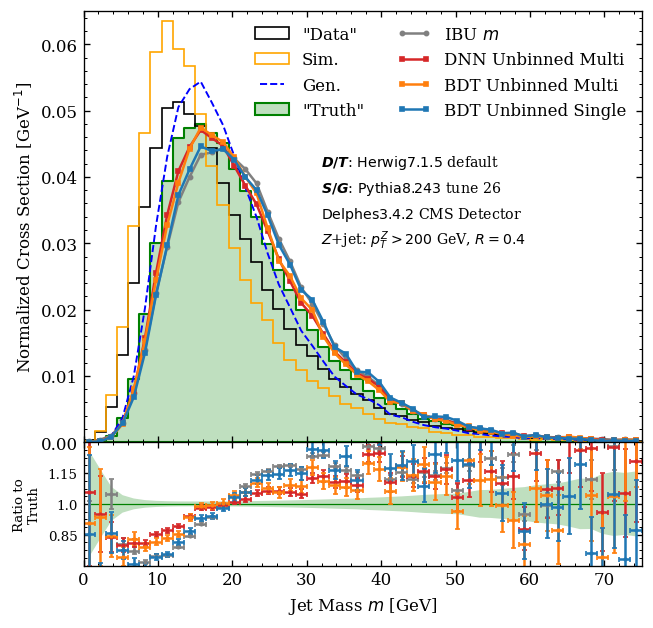

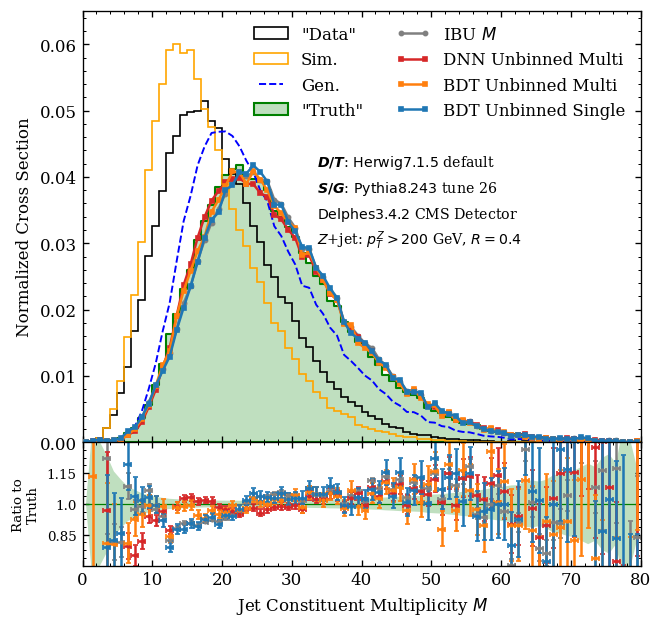

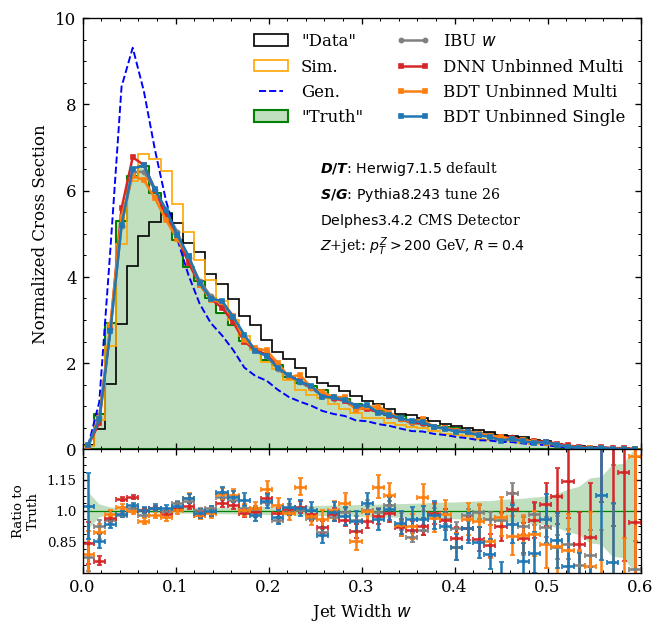

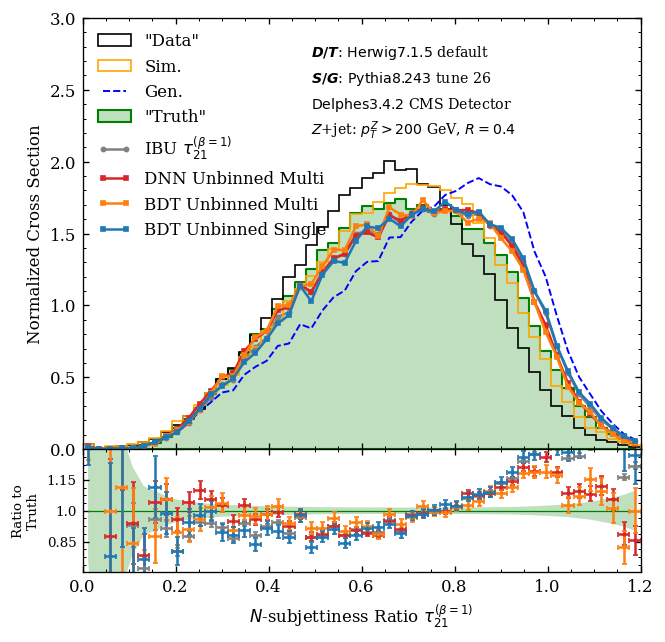

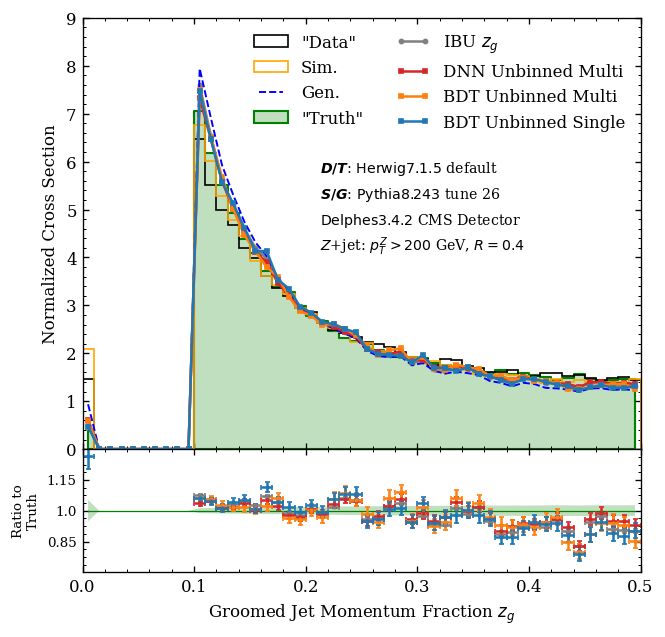

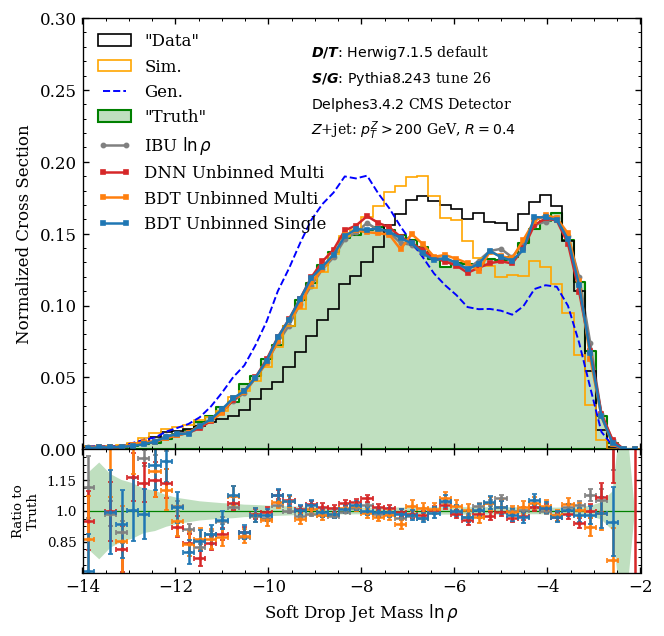

In [17]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob, figsize=(6,6))
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])
        
    # Plot the Different Distributions of the Observable
    if data: 
        ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='"Data"', **hist_style)
    if sim:
        ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)
    if mc:
        ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)
    if truth:
        ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    # plot the IBU distribution
    if ibu:
        ax0.plot(ob['ibu_bincenters'], ob['ibu'], **ibu_style, label='IBU ' + ob['symbol'])
    hist_range_low, hist_range_high = ob['xlim'][0], ob['xlim'][1]
    ob['histgen_dnn_unbinned_multi'], ob['histgen_unc_dnn_unbinned_multi'] = modplot.calc_hist(
        ob['genobs'], 
        weights=omnifold_dnn_weights, 
        bins=ob['bins_mc'], 
        hist_range = (hist_range_low, hist_range_high),
        density=True
    )[:2]

    ob['histgen_bdt_unbinned_multi'], ob['histgen_unc_bdt_unbinned_multi'] = modplot.calc_hist(
        MC_test_bdt[:,i], 
        weights=multifold_ws_bdt[-1][1],        
        bins=ob['bins_mc'], 
        hist_range = (hist_range_low, hist_range_high),
        density=True
    )[:2]
    ob['histgen_bdt_binned_single'], ob['histgen_unc_bdt_binned_single'] = modplot.calc_hist(
        bdt_binned_single_results[i][1].flatten(), 
        weights=bdt_binned_single_results[i][0][-1][1], 
        bins=ob['bins_mc'],
        hist_range = (hist_range_low, hist_range_high),
        density=True,
        efficiency = bdt_binned_single_results[i][2]
    )[:2]

    ob['histgen_bdt_unbinned_single'], ob['histgen_unc_bdt_unbinned_single'] = modplot.calc_hist(
        bdt_unbinned_single_results[i][1].flatten(), 
        weights=bdt_unbinned_single_results[i][0][-1][1], 
        bins=ob['bins_mc'],
        hist_range = (hist_range_low, hist_range_high),
        density=True
    )[:2]

    
    if dnn_unbinned_multi:
        ax0.plot(ob['midbins_mc'], ob['histgen_dnn_unbinned_multi'], **dnn_unbinned_multi_style, label='DNN Unbinned Multi')
    if bdt_unbinned_multi:
        ax0.plot(ob['midbins_mc'], ob['histgen_bdt_unbinned_multi'], **bdt_unbinned_multi_style, label='BDT Unbinned Multi')
    # if bdt_binned_single:
    #     ax0.plot(ob['midbins_mc'], ob['histgen_bdt_binned_single'], **bdt_binned_single_style, label='BDT Binned Single')
    if bdt_unbinned_single:
        ax0.plot(ob['midbins_mc'], ob['histgen_bdt_unbinned_single'], **bdt_unbinned_single_style, label='BDT Unbinned Single')


    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    ibu_ratio = ob['ibu'] / (ob['truth_hist'] + 10**-50)

    of_ratio_dnn_unbinned_multi = ob['histgen_dnn_unbinned_multi'] /(ob['truth_hist'] + 10**-50)
    of_ratio_bdt_unbinned_multi = ob['histgen_bdt_unbinned_multi'] /(ob['truth_hist'] + 10**-50)
    # of_ratio_bdt_binned_single = ob['histgen_bdt_binned_single'] /(ob['truth_hist'] + 10**-50)
    of_ratio_bdt_unbinned_single = ob['histgen_bdt_unbinned_single'] /(ob['truth_hist'] + 10**-50)

    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc'] / (ob['truth_hist'] + 10**-50)
    ibu_unc_ratio = ob['ibu_unc'] / (ob['truth_hist'] + 10**-50)

    of_unc_ratio_dnn_unbinned_multi = ob['histgen_unc_dnn_unbinned_multi'] / (ob['truth_hist'] + 10**-50)
    of_unc_ratio_bdt_unbinned_multi = ob['histgen_unc_bdt_unbinned_multi'] / (ob['truth_hist'] + 10**-50)
    # of_unc_ratio_bdt_binned_single = ob['histgen_unc_bdt_binned_single'] / (ob['truth_hist'] + 10**-50)
    of_unc_ratio_bdt_unbinned_single = ob['histgen_unc_bdt_unbinned_single'] / (ob['truth_hist'] + 10**-50)

    if truth_fill:
        ax1.fill_between(
            ob['midbins_mc'], 
            1 - truth_unc_ratio, 
            1 + truth_unc_ratio,          
            facecolor=truth_style['facecolor'], 
            zorder=-2
        )
    
    if ibu_err:
        ax1.errorbar(
        ob['ibu_bincenters'], 
        ibu_ratio, 
        xerr=(ob['ibu_bincenters'][1]-ob['ibu_bincenters'][0])/2, 
        yerr=ibu_unc_ratio,                       
        color=ibu_style['color'], 
        **modplot.style('errorbar')
    )

    if dnn_unbinned_multi_err:
        ax1.errorbar(
            ob['midbins_mc'],
            of_ratio_dnn_unbinned_multi,
            xerr=ob['binwidth_mc']/2,
            yerr=of_unc_ratio_dnn_unbinned_multi,
            color=dnn_unbinned_multi_style['color'],  # Added comma here
            **modplot.style('errorbar')
        ) # DNN Error Bar

    if bdt_unbinned_multi_err:
        ax1.errorbar(
            ob['midbins_mc'], 
            of_ratio_bdt_unbinned_multi, 
            xerr=ob['binwidth_mc']/2, 
            yerr=of_unc_ratio_bdt_unbinned_multi, 
            color=bdt_unbinned_multi_style['color'], 
            **modplot.style('errorbar')
        )

    # if bdt_binned_single_err:    
    #     ax1.errorbar(
    #         ob['midbins_mc'], 
    #         of_ratio_bdt_binned_single, 
    #         xerr=ob['binwidth_mc']/2, 
    #         yerr=of_unc_ratio_bdt_binned_single, 
    #         color=bdt_binned_single_style['color'], 
    #         **modplot.style('errorbar')
    #     ) # Binned Error Bar

    if bdt_unbinned_single_err:
        ax1.errorbar(
            ob['midbins_mc'], 
            of_ratio_bdt_unbinned_single, 
            xerr=ob['binwidth_mc']/2, 
            yerr=of_unc_ratio_bdt_unbinned_single, 
            color=bdt_unbinned_single_style['color'], 
            **modplot.style('errorbar')
        ) # Unbinned Error Bar


    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    modplot.legend(ax=ax0, frameon=False, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'$\boldsymbol{D/T}$: $\mathsf{Herwig 7.1.5}$ default',
                  line_1=r'$\boldsymbol{S/G}$: $\mathsf{Pythia 8.243}$ tune 26',
                  line_2=r'$\mathsf{Delphes 3.4.2}$ CMS Detector',
                  line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')

    # save plot (by default in the same directory as this notebook). 

    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig(f'./plots/OmniFold_{obkey}_150pT_cut.png', bbox_inches='tight')
    plt.show()

# Computing Triangular Discriminator

In [18]:
def triangular_discriminator(p, q):
    p = np.array(p)
    q = np.array(q)
    if len(p) != len(q):
        print("Error: The distributions 'p' and 'q' must have the same length.")
        return None
    
    epsilon = 1e-50
    discriminator = np.sum((p - q)**2 / (p + q + epsilon))
    return 0.5 * discriminator


In [19]:
triangular_discriminator_results = {}

# Iterate through each observable in obs.items()
for obkey, ob in obs.items():
    if 'truth_hist' in ob:
        truth_hist = ob['truth_hist']
        # Dictionary to store triangular discriminator values for this observable
        discriminator_values = {
            'dnn_unbinned_multi': triangular_discriminator(ob['histgen_dnn_unbinned_multi'], truth_hist),
            'bdt_unbinned_multi': triangular_discriminator(ob['histgen_bdt_unbinned_multi'], truth_hist),
            # 'bdt_binned_single': triangular_discriminator(ob['histgen_bdt_binned_single'], truth_hist),
            'bdt_unbinned_single': triangular_discriminator(ob['histgen_bdt_unbinned_single'], truth_hist),
            'ibu': triangular_discriminator(ob['ibu'], truth_hist),
            'data': triangular_discriminator(ob['data_hist'], truth_hist),
            'gen': triangular_discriminator(ob['genobs_hist'], truth_hist)
        }
        
        # Add the results for this observable (obkey) to the main results dictionary
        triangular_discriminator_results[obkey] = discriminator_values

time_values = {
    'dnn_unbinned_multi': dnn_unbinned_multi_time,
    'bdt_unbinned_multi': bdt_unbinned_multi_time,
    # 'bdt_binned_single': bdt_binned_single_time,
    'bdt_unbinned_single': bdt_unbinned_single_time,
    'ibu': ibu_time,
    'data': 0,
    'gen': 0
}

# Add the results for this observable (obkey) to the main results dictionary
triangular_discriminator_results["time"] = time_values
        
# Convert the results dictionary to a DataFrame
df_results = pd.DataFrame(triangular_discriminator_results)
# Display the DataFrame
df_results.reset_index(inplace=True)

# Rename the current 'index' column to 'discriminator'
df_results.rename(columns={'index': 'Model name'}, inplace=True)

# Set 'discriminator' as the index
df_results.set_index('Model name', inplace=True)
df_results.to_csv(f'./data/OmniFold_150pT_test.csv')
df_results


,Mass,Mult,Width,Tau21,zg,SDMass,time
Model name,,,,,,,
dnn_unbinned_multi,0.001642,0.000841,0.055078,0.099874,0.083539,0.002121,246.007491
bdt_unbinned_multi,0.002149,0.000916,0.067777,0.065642,0.120800,0.002337,229.530431
bdt_unbinned_single,0.005136,0.001762,0.080899,0.196995,0.118635,0.001545,267.159279
ibu,0.005102,0.001504,0.039899,0.158579,0.094273,0.001983,0.017635
data,0.016915,0.131155,1.305439,0.463365,0.401175,0.057177,0.000000
gen,0.002708,0.016355,1.970925,0.881610,0.350570,0.083996,0.000000


In [20]:
no_stop_df = pd.read_csv(f'./data/OmniFold_150pT_highstat.csv')
no_stop_df

,Model name,Mass,Mult,Width,Tau21,zg,SDMass,time
0,dnn_unbinned_multi,0.001282,0.000154,0.053620,0.087133,0.096431,0.001608,4248.012435
1,bdt_unbinned_multi,0.002766,0.002498,0.136903,0.107535,0.103785,0.016791,3252.383585
2,bdt_binned_single,0.005161,0.001102,0.026592,0.147913,0.077768,0.001388,735.669865
3,bdt_unbinned_single,0.000761,0.000622,0.137872,0.143495,0.129584,0.011029,3867.274174
4,ibu,0.004923,0.001112,0.023255,0.140570,0.087775,0.001358,0.253637
5,data,0.016539,0.130158,1.308848,0.468887,0.371254,0.058665,0.000000
6,gen,0.002476,0.014926,1.859108,0.864937,0.376615,0.079622,0.000000
